## Tutorial : Automatically determining TF binding site locations

The code in this tutorial is released under the [MIT License](https://opensource.org/licenses/MIT). All the content in this notebook is under a [CC-by 4.0 License](https://creativecommons.org/licenses/by/4.0/). 

Created by Bill Ireland, Suzy Beleer and Manu Flores. 

In [1]:
#Import basic stuff
import matplotlib.pyplot as plt
import numpy as np

#import the custom analysis software
import scipy as sp
import seaborn as sns
import viz

# Set PBoC plotting style 
viz.pboc_style_mpl()

# Activate a setting that causes all plots to be inside the notebook rather than in pop-ups.
%matplotlib inline
# Get svg graphics from the notebook
%config InlineBackend.figure_format = 'svg' 

To determine locations of binding sites automatically, we must take the information footprints and expression shift plots (which we demonstrate how to generate in the information footprint tutorial). We determine which ones are truly part of binding sites. To do this we will first determine which base pairs have a signficant impact on gene expression. Then if there are 5 or more significant base pairs within a 15 base pair region, then we tentatively classify that area as a binding site. These areas need to be reviewed by hand.

To determine which base pairs have significant impacts on gene expression, we will use the MCMC sampling done when inferring the expression shift to determine the uncertainty in each measurement.

First we will load in the MCMC samples

In [3]:
#We will declare the path where all the data for this notebook is stored.
path = '../datasets/'

In [4]:
#we will look at the aphA gene in a low oxygen growth condition.
genelabel = 'aphA'
#We load in each sample in the MCMC run. These are also stored in the datasets/ folder. We store each
#MCMC run as a pickle file (.npy) or an sqlite database (.sql)
MCMC_samples = np.load(path + 'aphAheat_database.npy')
#remove burnin samples. At the start of any MCMC run there will be a 'burnin' period where the sampler
#will not be in a region of high likelihood. In our case we will be safely past it after 60000 iterations.
#We thin samples (only save 1 out of ever 60 samples). So we will throw out the first 1000 saved samples
#to avoid the burnin period.
MCMC_burnin = MCMC_samples[1000:,:]
parameter_to_check = 0

We can then look at the distributions of the MCMC samples for a given parameter. We can then construct a confidence interval for the parameter.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


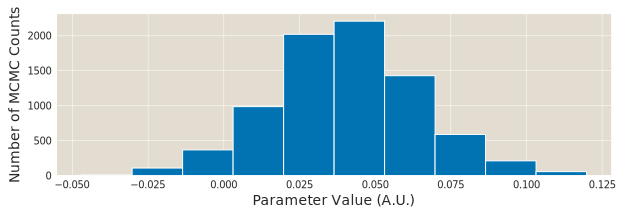

In [5]:
fig,ax = plt.subplots(figsize=(10,3))
plt.hist(MCMC_burnin[:,parameter_to_check])
ax.set_ylabel('Number of MCMC Counts')
ax.set_xlabel('Parameter Value (A.U.)')
plt.show()

The confidence interval is then

In [6]:
#We take the mean of all MCMC samples to get the parameter value.
mean_value = np.mean(MCMC_burnin[:,parameter_to_check],axis=0)

#We then determine statistical significance, if the mean value is greater than zero, we will check
#if five percent or more samples are less than zero.
if mean_value > 0:
    #We generate the confidence interval by checking where the 5th percentile of all values are.
    CI = np.percentile(MCMC_burnin[:,parameter_to_check],[5,100])
else:
    #We generate the confidence interval by checking where the 95th percentile of all values are.
    CI = np.percentile(MCMC_burnin[:,parameter_to_check],[0,95])

In [7]:
#we can display the confidence interval now.
print(CI)

[0.00015512 0.11985067]


We see that 0 is within the conficent interval, so it does not have a significant effect on expression. We then determine similar information for each base pair.

In [8]:
#initialize an array to store whether or not a given base pair is significant. If it is we will store 'True'.
#Otherwise we will store 'False'
all_significance = np.zeros((160))

#loop through the 160 base pair region.
for i in range(160):
    
    #determine confidence interval as in the above panel.
    mean_value = np.mean(MCMC_burnin[:,i],axis=0)
    if mean_value > 0:
        CI = np.percentile(MCMC_burnin[:,i],[5,100])
    else:
        CI = np.percentile(MCMC_burnin[:,i],[0,95])
    #we now check if 0 in the confidence interval. If it is not, we label the significance of
    #the base pair location as 'True'.
    if 0 > CI[0] and 0 < CI[1]:
        all_significance[i] = False
    else:
        all_significance[i] = True

We will plot the results with significant base pair in red.

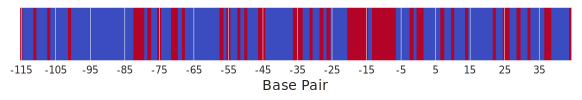

In [9]:
fig,ax = plt.subplots(figsize=(10,1))
plt.imshow(all_significance[np.newaxis,:],aspect='auto',cmap='coolwarm')
plt.yticks([])
ax.set_xlabel('Base Pair')
ax.set_xticks(np.arange(0,160,10))
ax.set_xticklabels(np.arange(-115,45,10))
plt.show()

We then check if there are 5 or more significant base pairs in a 15 base pair region. If so, we will declare it part of a binding site.

In [10]:
# we are looking at 15 base pair windows so we only need 145 entries.
TF_locations = np.zeros(145)

for i in range(145):
    #we get the total number of significant base pairs and see if that is 5 or more.
    if all_significance[i:i+15].sum() > 4:
        TF_locations[i] = True
    else:
        TF_locations[i] = False

Now we can plot the final results.

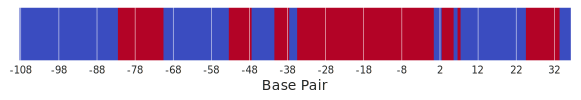

In [11]:
fig,ax = plt.subplots(figsize=(10,1))
plt.imshow(TF_locations[np.newaxis,:],aspect='auto',cmap='coolwarm')
plt.yticks([])
ax.set_xlabel('Base Pair')
ax.set_xticks(np.arange(0,145,10))
ax.set_xticklabels(np.arange(-108,38,10))
plt.show()

We see that there are multiple locations identified by this method. We can see regions from -82 to -70, -53 to -47, -41 to -37, -33 to to 1, 3 to 8, and 25 to 34. The region from -82 to -70 corresponds to a confirmed DeoR binding site and the -53 to -47 binding region corresponds to a part of a known FNR binding site. All regulatory regions from -41 to 1 correspond to an RNAP binding site. 

However, the downstream regions are unlikely to correspond to true TF binding sites. This automated method includes the discovered binding sites of the *aphA* gene but also includes some secondary RNAP binding sites and some likely false positives, such as the region downstream of the TSS (2 to 10 bp). The results show that this method is useful but also we need to review all results.